# Prep

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.2 MB/s eta 0:00:00


In [2]:
import os
import shutil
import time
from google.colab import drive

# ==========================================
# 1. MOUNT DRIVE (The "Vault")
# ==========================================
# This gives access to your permanent storage
drive.mount('/content/drive')

# Paths
DRIVE_ZIP_PATH = '/content/drive/MyDrive/Oxford/study/VIS/phase_1/trainxs.zip'
LOCAL_ZIP_PATH = '/content/trainxs.zip'
LOCAL_DATA_DIR = '/content/data_local'
GCP_KEY_PATH = '/content/drive/MyDrive/Oxford/study/VIS/phase_1/colab-upload-bot-key.json'
LOCAL_GCP_KEY_PATH = '/content/colab-upload-bot-key.json'
ANNOTATION_PATH = '/content/drive/MyDrive/Oxford/study/VIS/phase_1/annotations/train.json'
LOCAL_ANNOTATION_PATH = '/content/train.json'

# ==========================================
# 2. COPY & UNZIP (The Speed Hack)
# ==========================================

shutil.copy(GCP_KEY_PATH, LOCAL_GCP_KEY_PATH)
shutil.copy(ANNOTATION_PATH, LOCAL_ANNOTATION_PATH)

if not os.path.exists(LOCAL_DATA_DIR):
    print("🚀 Copying data from Drive to Local SSD (Fast)...")
    t0 = time.time()

    # Copy the ZIP from Drive to Colab Local Disk
    shutil.copy(DRIVE_ZIP_PATH, LOCAL_ZIP_PATH)

    print(f"📦 Unzipping... (This is fast on Colab SSD)")
    # Unzip quietly (-q) to avoiding spamming output
    os.system(f'unzip -q {LOCAL_ZIP_PATH} -d {LOCAL_DATA_DIR}')

    t1 = time.time()
    print(f"✅ Data Ready! Setup took: {t1-t0:.2f}s")
else:
    print("✅ Data already loaded locally.")

# ==========================================
# 3. CONFIGURE YOUR STRATEGY
# ==========================================
# Point your existing code to look at the LOCAL folder, not Drive
TRAIN_DIR = os.path.join(LOCAL_DATA_DIR, 'trainxs')
# (Make sure this matches the folder structure inside your zip)

Mounted at /content/drive
🚀 Copying data from Drive to Local SSD (Fast)...
📦 Unzipping... (This is fast on Colab SSD)
✅ Data Ready! Setup took: 66.36s


# Run the Pipeline

In [3]:
# ==========================================
# 1. SETUP & IMPORTS
# ==========================================
import glob
import cv2
import json
import sys
import pandas as pd
import numpy as np
import warnings
import math
from collections import defaultdict

warnings.simplefilter(action='ignore', category=FutureWarning)

# ==========================================
# 2. AUTHENTICATION & DATA VERIFICATION
# ==========================================
OUTPUT_CSV_PATH = './strat_1_cpu.csv'
SHOULD_LIMIT_VIDEO = 1
# Set if SHOULD_LIMIT_VIDEO == 1
VIDEO_INDEX = 1

print(f"\n🚀 CHECKING DATA...")

# A. Check Annotations
if not os.path.exists(LOCAL_ANNOTATION_PATH):
    print(f"⬇️ 'train.json' not found")
    if os.path.exists(ANNOTATION_PATH):
        print(f"⬇️ 'train.json' Downloading...")
        shutil.copy(ANNOTATION_PATH, LOCAL_ANNOTATION_PATH)
else:
    print("✅ Annotations found locally.")

# B. Check Video Data
if os.path.exists(TRAIN_DIR) and len(os.listdir(TRAIN_DIR)) > 0:
    print(f"✅ Training data found in '{TRAIN_DIR}'. Skipping download.")
else:
    print(f"⬇️ Data not found. Downloading from Drive...")
    t0 = time.time()
    shutil.copy(DRIVE_ZIP_PATH, LOCAL_ZIP_PATH)
    print(f"📦 Unzipping... (This is fast on Colab SSD)")
    os.system(f'unzip -q {LOCAL_ZIP_PATH} -d {LOCAL_DATA_DIR}')
    t1 = time.time()
    print(f"✅ Data Ready! Setup took: {t1-t0:.2f}s")

# ==========================================
# 3. MOTION COMPENSATION LOGIC (CPU)
# ==========================================
def align_frames(prev_gray, curr_gray):
    """
    Calculates camera motion and warps prev_gray to match curr_gray.
    """
    # 1. Detect Features
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, maxCorners=200, qualityLevel=0.01, minDistance=30)
    if prev_pts is None: return None

    # 2. Optical Flow
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None)
    good_prev = prev_pts[status == 1]
    good_curr = curr_pts[status == 1]

    if len(good_prev) < 4: return None

    # 3. Find Homography
    H, mask = cv2.findHomography(good_prev, good_curr, cv2.RANSAC, 5.0)
    if H is None: return None

    # 4. Warp
    height, width = prev_gray.shape
    warped_prev = cv2.warpPerspective(prev_gray, H, (width, height))
    return warped_prev

# ==========================================
# 4. HELPER FUNCTIONS (METRICS & TRACKING)
# ==========================================
def load_json_ground_truth(json_path):
    if not os.path.exists(json_path): return {}
    with open(json_path, 'r') as f: data = json.load(f)
    id_to_filename = {img['id']: img['file_name'] for img in data['images']}
    img_id_to_boxes = defaultdict(list)
    if 'annotations' in data:
        for ann in data['annotations']:
            img_id_to_boxes[ann['image_id']].append(ann['bbox'])
    filename_to_gt = {}
    for img_id, filename in id_to_filename.items():
        key = filename.replace('train/', '', 1) if filename.startswith('train/') else filename
        filename_to_gt[key] = img_id_to_boxes.get(img_id, [])
    return filename_to_gt

def get_center(box):
    # box = [x, y, w, h]
    return (box[0] + box[2]/2, box[1] + box[3]/2)

def calculate_center_distance(box1, box2):
    """Euclidean distance between centers of two boxes."""
    c1 = get_center(box1)
    c2 = get_center(box2)
    return math.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2)

class ObjectTracker:
    def __init__(self, dist_thresh=50, max_frames_to_skip=5, min_hits=3):
        self.tracks = []
        self.track_id_count = 0
        self.dist_thresh = dist_thresh
        self.max_frames_to_skip = max_frames_to_skip
        self.min_hits = min_hits

    def update(self, detections):
        """
         detections: list of [x, y, w, h]
         Returns: list of valid tracks [x, y, w, h] that met min_hits
        """
        # detections is a list of boxes
        if len(self.tracks) == 0:
            for det in detections:
                self.tracks.append({'box': det, 'id': self.track_id_count, 'hits': 1, 'skipped': 0})
                self.track_id_count += 1
            return []

        # Simple Greedy Matching
        # Create a cost matrix (Distance)
        # For simplicity in this script, we loop through tracks and find closest detection

        assigned_dets = set()

        for track in self.tracks:
            best_dist = self.dist_thresh
            best_det_idx = -1

            for i, det in enumerate(detections):
                if i in assigned_dets: continue
                d = calculate_center_distance(track['box'], det)
                if d < best_dist:
                    best_dist = d
                    best_det_idx = i

            if best_det_idx != -1:
                # HIT: Update track
                track['box'] = detections[best_det_idx]
                track['hits'] += 1
                track['skipped'] = 0
                assigned_dets.add(best_det_idx)
            else:
                # MISS: Increment skip
                track['skipped'] += 1

        # Create new tracks for unassigned detections
        for i, det in enumerate(detections):
            if i not in assigned_dets:
                self.tracks.append({'box': det, 'id': self.track_id_count, 'hits': 1, 'skipped': 0})
                self.track_id_count += 1

        # Remove dead tracks
        self.tracks = [t for t in self.tracks if t['skipped'] <= self.max_frames_to_skip]

        # Return only tracks that are "warmed up" (min_hits)
        valid_boxes = [t['box'] for t in self.tracks if t['hits'] >= self.min_hits]
        return valid_boxes

def get_next_version_path(path):
    if not os.path.exists(path): return path
    directory, filename = os.path.split(path)
    name, ext = os.path.splitext(filename)
    if directory and not os.path.exists(directory): os.makedirs(directory)
    pattern = cv2.os.re.compile(rf"^{cv2.os.re.escape(name)}_(\d+){cv2.os.re.escape(ext)}$")
    max_version = 0
    for f in os.listdir(directory if directory else '.'):
        match = cv2.os.re.match(rf"^{name}_(\d+){ext}$", f)
        if match:
            version = int(match.group(1))
            if version > max_version: max_version = version
    return os.path.join(directory, f"{name}_{max_version + 1}{ext}")

# ==========================================
# 5. MAIN PIPELINE
# ==========================================
def run_gmc_evaluation():
    gt_data = load_json_ground_truth(LOCAL_ANNOTATION_PATH)
    if not gt_data: return

    start_time = time.time()
    video_folders = sorted(glob.glob(os.path.join(TRAIN_DIR, '*')))
    video_folders = [f for f in video_folders if os.path.isdir(f)]
    if SHOULD_LIMIT_VIDEO:
      if VIDEO_INDEX < len(video_folders) and SHOULD_LIMIT_VIDEO == 1:
        video_folders = [video_folders[VIDEO_INDEX]]
      else:
        video_folders = video_folders[:SHOULD_LIMIT_VIDEO]

    if not video_folders:
        print(f"❌ No video folders found in {TRAIN_DIR}.")
        return

    print(f"📂 Found {len(video_folders)} videos. Starting GMC + Tracking (CPU)...")
    print(f"\n{'Video':<10} | {'Frames':<6} | {'FPS':<6} | {'Prec':<6} | {'Recall':<6} | {'F1':<6}")
    print("-" * 65)

    total_tp = total_fp = total_fn = total_time = total_frames = 0
    results_data = []

    for video_path in video_folders:
        video_name = os.path.basename(video_path)
        images = sorted(glob.glob(os.path.join(video_path, '*.jpg')))
        if not images: continue

        vid_tp = vid_fp = vid_fn = 0
        vid_start = time.time()
        n_frames = len(images)
        prev_gray = None

        # Initialize Tracker for this video
        tracker = ObjectTracker(dist_thresh=50, min_hits=3)

        for i, img_path in enumerate(images):
            if i % 50 == 0:
                percent = ((i + 1) / n_frames) * 100
                sys.stdout.write(f"\r👉 Processing [{video_name}] Frame {i+1}/{n_frames} ({percent:.1f}%)")
                sys.stdout.flush()

            frame = cv2.imread(img_path)
            if frame is None: continue
            curr_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            raw_detections = []

            if prev_gray is not None:
                warped_prev = align_frames(prev_gray, curr_gray)
                if warped_prev is not None:
                    # Difference Logic
                    diff = cv2.absdiff(curr_gray, warped_prev)
                    _, thresh = cv2.threshold(diff, 50, 255, cv2.THRESH_BINARY)

                    # Morphological Cleaning
                    kernel = np.ones((3,3), np.uint8)
                    thresh = cv2.dilate(thresh, kernel, iterations=2)
                    thresh = cv2.erode(thresh, kernel, iterations=1)

                    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    h_img, w_img = curr_gray.shape

                    for cnt in contours:
                        area = cv2.contourArea(cnt)
                        # Filter noise
                        if 50 < area < 3000:
                            x, y, w, h = cv2.boundingRect(cnt)
                            # Border check
                            border = 10
                            if x > border and y > border and (x+w) < (w_img-border) and (y+h) < (h_img-border):
                                raw_detections.append([x, y, w, h])

            prev_gray = curr_gray

            # --- TRACKING STEP ---
            # Pass raw detections to tracker to get stable ones
            final_preds = tracker.update(raw_detections)
            # ---------------------

            # Evaluation (Center Distance)
            key = f"{video_name}/{os.path.basename(img_path)}"
            gts = gt_data.get(key, [])
            matched_gt = set()

            for p_box in final_preds:
                best_dist = 10000
                best_idx = -1
                for idx, g_box in enumerate(gts):
                    if idx in matched_gt: continue
                    d = calculate_center_distance(p_box, g_box)
                    if d < best_dist: best_dist = d; best_idx = idx

                # Threshold: 30 pixels distance allowed
                if best_dist <= 30:
                    vid_tp += 1
                    matched_gt.add(best_idx)
                else:
                    vid_fp += 1

            vid_fn += len(gts) - len(matched_gt)

        vid_time = time.time() - vid_start
        fps = len(images) / vid_time if vid_time > 0 else 0
        prec = vid_tp / (vid_tp + vid_fp) if (vid_tp + vid_fp) > 0 else 0
        rec = vid_tp / (vid_tp + vid_fn) if (vid_tp + vid_fn) > 0 else 0
        f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

        sys.stdout.write("\r" + " " * 80 + "\r")
        print(f"{video_name:<10} | {len(images):<6} | {fps:<6.1f} | {prec:<6.2f} | {rec:<6.2f} | {f1:<6.2f}")

        results_data.append({
            'Video': video_name, 'Frames': len(images), 'FPS': round(fps, 2),
            'Precision': round(prec, 4), 'Recall': round(rec, 4), 'F1': round(f1, 4),
            'TP': vid_tp, 'FP': vid_fp, 'FN': vid_fn
        })
        total_time += vid_time; total_frames += len(images)
        total_tp += vid_tp; total_fp += vid_fp; total_fn += vid_fn

    avg_fps = total_frames / total_time if total_time > 0 else 0
    overall_prec = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    overall_rec = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    overall_f1 = 2 * (overall_prec * overall_rec) / (overall_prec + overall_rec) if (overall_prec + overall_rec) > 0 else 0

    print("=" * 65)
    print("FINAL RESULTS (Tracked + CenterDist):")
    print(f"Total Frames:   {total_frames}")
    print(f"Average FPS:    {avg_fps:.2f}")
    print(f"Precision:      {overall_prec:.4f}")
    print(f"Recall:         {overall_rec:.4f}")
    print(f"F1-Score:       {overall_f1:.4f}")
    print("=" * 65)

    df = pd.DataFrame(results_data)
    # Simple versioning logic since regex might fail in some envs
    final_path = OUTPUT_CSV_PATH
    if os.path.exists(final_path):
        final_path = final_path.replace(".csv", "_new.csv")

    df.to_csv(final_path, index=False)
    print(f"✅ CSV Saved: {final_path}")

if __name__ == "__main__":
    run_gmc_evaluation()


🚀 CHECKING DATA...
✅ Annotations found locally.
✅ Training data found in '/content/data_local/trainxs'. Skipping download.
📂 Found 2 videos. Starting GMC + Tracking (CPU)...

Video      | Frames | FPS    | Prec   | Recall | F1    
-----------------------------------------------------------------
0001       | 601    | 0.3    | 0.00   | 0.85   | 0.00  
0002       | 597    | 2.1    | 0.24   | 0.09   | 0.13  
FINAL RESULTS (Tracked + CenterDist):
Total Frames:   1198
Average FPS:    0.51
Precision:      0.0002
Recall:         0.2265
F1-Score:       0.0004
✅ CSV Saved: ./strat_1_cpu.csv


# Debug

🎯 Limiting Visualization to ONLY Video Index: 1
🕵️ Starting Scan across 1 videos...

🎬 VIDEO 1/1: 0002
   Scanning frame 0/597...
   📸 Frame 5: ✅ HIT (Accurate Detection)


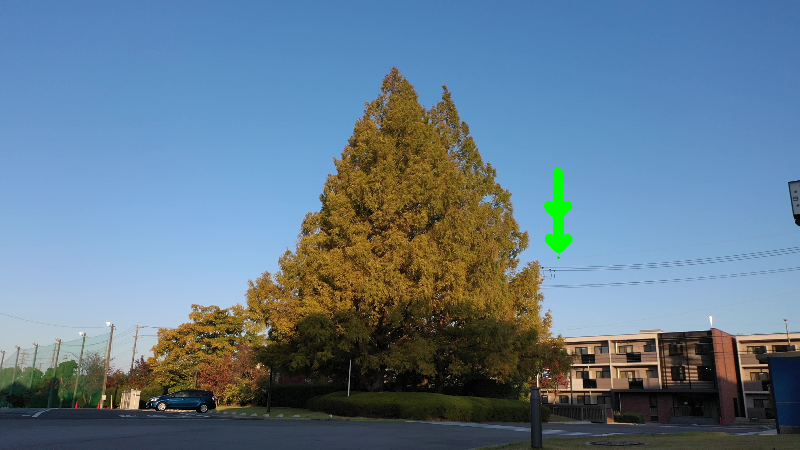

   Scanning frame 40/597...
   📸 Frame 52: ⚠️ DISTRACTION (Predicted wrong object)


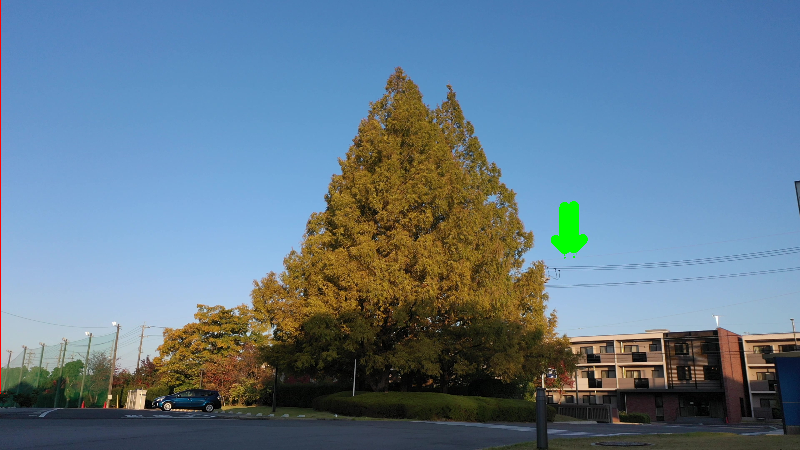

   ✅ Found examples. Moving to next video.


In [12]:
# ==========================================
# SMART VISUALIZATION (STRATEGY - LIMIT RESPECTED)
# ==========================================
import glob
import os
import cv2
import sys
import numpy as np
from google.colab.patches import cv2_imshow

# Tracker Class (Required for Strategy Viz)
class ObjectTracker:
    def __init__(self, dist_thresh=50, min_hits=3):
        self.tracks = []
        self.track_id_count = 0
        self.dist_thresh = dist_thresh
        self.min_hits = min_hits

    def update(self, detections):
        if len(self.tracks) == 0:
            for det in detections:
                self.tracks.append({'box': det, 'id': self.track_id_count, 'hits': 1, 'skipped': 0})
                self.track_id_count += 1
            return []

        assigned_dets = set()
        for track in self.tracks:
            best_dist = self.dist_thresh
            best_det_idx = -1
            for i, det in enumerate(detections):
                if i in assigned_dets: continue
                # Euclidean distance center-to-center
                cx_t, cy_t = track['box'][0]+track['box'][2]/2, track['box'][1]+track['box'][3]/2
                cx_d, cy_d = det[0]+det[2]/2, det[1]+det[3]/2
                d = ((cx_t-cx_d)**2 + (cy_t-cy_d)**2)**0.5

                if d < best_dist:
                    best_dist = d
                    best_det_idx = i

            if best_det_idx != -1:
                track['box'] = detections[best_det_idx]
                track['hits'] += 1
                track['skipped'] = 0
                assigned_dets.add(best_det_idx)
            else:
                track['skipped'] += 1

        for i, det in enumerate(detections):
            if i not in assigned_dets:
                self.tracks.append({'box': det, 'id': self.track_id_count, 'hits': 1, 'skipped': 0})
                self.track_id_count += 1

        self.tracks = [t for t in self.tracks if t['skipped'] <= 5]
        return [t['box'] for t in self.tracks if t['hits'] >= self.min_hits]

# Helper Functions
def boxes_intersect(boxA, boxB):
    ax1, ay1, ax2, ay2 = boxA[0], boxA[1], boxA[0]+boxA[2], boxA[1]+boxA[3]
    bx1, by1, bx2, by2 = boxB[0], boxB[1], boxB[0]+boxB[2], boxB[1]+boxB[3]
    if (ax1 > bx2) or (ax2 < bx1) or (ay1 > by2) or (ay2 < by1): return False
    return True

def draw_arrow_pointer(img, x, y, w, h, color=(0, 255, 0)):
    center_x = int(x + w // 2)
    gap = 40
    arrow_len = 200
    if y < (gap + arrow_len):
        start_point = (center_x, y + h + gap + arrow_len)
        end_point = (center_x, y + h + gap)
    else:
        start_point = (center_x, y - gap - arrow_len)
        end_point = (center_x, y - gap)
    cv2.arrowedLine(img, start_point, end_point, color, thickness=50, tipLength=0.3)

def align_frames(prev_gray, curr_gray):
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, maxCorners=200, qualityLevel=0.01, minDistance=30)
    if prev_pts is None: return None
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None)
    good_prev = prev_pts[status == 1]
    good_curr = curr_pts[status == 1]
    if len(good_prev) < 4: return None
    H, mask = cv2.findHomography(good_prev, good_curr, cv2.RANSAC, 5.0)
    if H is None: return None
    height, width = prev_gray.shape
    return cv2.warpPerspective(prev_gray, H, (width, height))

def load_json_ground_truth(json_path):
    if not os.path.exists(json_path): return {}
    with open(json_path, 'r') as f: data = json.load(f)
    id_to_filename = {img['id']: img['file_name'] for img in data['images']}
    img_id_to_boxes = {}
    if 'annotations' in data:
        for ann in data['annotations']:
            if ann['image_id'] not in img_id_to_boxes: img_id_to_boxes[ann['image_id']] = []
            img_id_to_boxes[ann['image_id']].append(ann['bbox'])
    filename_to_gt = {}
    for img_id, filename in id_to_filename.items():
        key = filename.replace('train/', '', 1) if filename.startswith('train/') else filename
        filename_to_gt[key] = img_id_to_boxes.get(img_id, [])
    return filename_to_gt

# Main Viz Function
def visualize_strategy_smart_all_videos():
    search_path = os.path.join(TRAIN_DIR, '*')
    video_folders = sorted(glob.glob(search_path))
    video_folders = [f for f in video_folders if os.path.isdir(f)]

    # --- FILTERING LOGIC (MATCHES CELL 2) ---
    if SHOULD_LIMIT_VIDEO:
        if SHOULD_LIMIT_VIDEO == 1 and VIDEO_INDEX < len(video_folders):
            print(f"🎯 Limiting Visualization to ONLY Video Index: {VIDEO_INDEX}")
            video_folders = [video_folders[VIDEO_INDEX]]
        else:
            print(f"🎯 Limiting Visualization to first {SHOULD_LIMIT_VIDEO} videos.")
            video_folders = video_folders[:SHOULD_LIMIT_VIDEO]
    # ----------------------------------------

    if not video_folders:
        print(f"❌ No videos found in: {TRAIN_DIR}")
        return

    gt_data = load_json_ground_truth(LOCAL_ANNOTATION_PATH)
    print(f"🕵️ Starting Scan across {len(video_folders)} videos...")

    for v_idx, target_video in enumerate(video_folders):
        video_name = os.path.basename(target_video)
        images = sorted(glob.glob(os.path.join(target_video, '*.jpg')))

        print(f"\n==========================================")
        print(f"🎬 VIDEO {v_idx+1}/{len(video_folders)}: {video_name}")
        print(f"==========================================")

        tracker = ObjectTracker(dist_thresh=50, min_hits=3)
        prev_gray = None
        hit_found = False
        distraction_found = False

        for i, img_path in enumerate(images):
            # Optim: Stop if we found both examples for this video
            if hit_found and distraction_found:
                print("   ✅ Found examples. Moving to next video.")
                break

            if i % 20 == 0:
                sys.stdout.write(f"\r   Scanning frame {i}/{len(images)}...")
                sys.stdout.flush()

            frame = cv2.imread(img_path)
            curr_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # --- RUN PIPELINE ---
            raw_detections = []
            if prev_gray is not None:
                warped_prev = align_frames(prev_gray, curr_gray)
                if warped_prev is not None:
                    diff = cv2.absdiff(curr_gray, warped_prev)
                    _, thresh = cv2.threshold(diff, 50, 255, cv2.THRESH_BINARY)
                    kernel = np.ones((3,3), np.uint8)
                    thresh = cv2.dilate(thresh, kernel, iterations=2)
                    thresh = cv2.erode(thresh, kernel, iterations=1)
                    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    for cnt in contours:
                        if 50 < cv2.contourArea(cnt) < 3000:
                            raw_detections.append(list(cv2.boundingRect(cnt)))

            prev_gray = curr_gray
            final_preds = tracker.update(raw_detections)

            # --- ANALYZE FRAME ---
            key = f"{video_name}/{os.path.basename(img_path)}"
            gts = gt_data.get(key, [])

            has_overlap = False
            has_separation = False

            if len(gts) > 0 and len(final_preds) > 0:
                overlap_count = 0
                for p in final_preds:
                    for g in gts:
                        if boxes_intersect(p, g):
                            overlap_count += 1
                if overlap_count > 0: has_overlap = True
                else: has_separation = True

            show_it = False
            label = ""

            if has_overlap and not hit_found:
                show_it = True
                hit_found = True
                label = "✅ HIT (Accurate Detection)"

            elif has_separation and not distraction_found:
                show_it = True
                distraction_found = True
                label = "⚠️ DISTRACTION (Predicted wrong object)"

            if show_it:
                print(f"\n   📸 Frame {i}: {label}")

                # 1. Draw Preds (Red)
                for box in final_preds:
                    x, y, bw, bh = map(int, box)
                    cv2.rectangle(frame, (x, y), (x+bw, y+bh), (0, 0, 255), 2)
                    cv2.putText(frame, "Pred", (x, y+bh+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

                # 2. Draw GT (Green) + ARROWS
                for box in gts:
                    x, y, bw, bh = map(int, box)
                    cv2.rectangle(frame, (x, y), (x+bw, y+bh), (0, 255, 0), 2)
                    cv2.putText(frame, "GT", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
                    draw_arrow_pointer(frame, x, y, bw, bh, color=(0, 255, 0))

                h, w = frame.shape[:2]
                if w > 800: frame = cv2.resize(frame, (800, int(h * 800/w)))
                cv2_imshow(frame)

visualize_strategy_smart_all_videos()